In [1]:
from pv_model import model_pv_power
import matplotlib.pyplot as plt
import pandas as pd
import pvlib

In [2]:
# Make a dictionary with plant specs for 3 hypothetical plants:
# Thin-film tracker plant in Macon, crystalline tracker plant in Albany,
# and crystalline fixed tilt plant in Savannah
# Macon: 32.8, -83.6
# Albany: 31.6, -84.2
# Savannah: 32.1, -81.1

plant_dict = {
    'latitude': [32.8, 32.8, 32.8, 32.8],
    'longitude': [-83.6, -83.6, -83.6, -83.6],
    'mount_type': ['single-axis', 'single-axis', 'fixed', 'fixed'],
    'max_tracker_angle': [60, 60, None, None],
    'axis_azimuth': [180, 180, None, None],
    'axis_tilt': [0, 0, None, None],
    'fixed_tilt': [None, None, 20, 20],
    'fixed_azimuth': [None, None, 180, 180],
    'gcr': [0.35, 0.35, 0.6, 0.6],
    'nameplate_dc': [120, 120, 120, 120],
    'nameplate_ac': [100, 100, 100, 100],
    'cell_type': ['crystalline_half-cut', 'crystalline_half-cut', 'crystalline_half-cut', 'crystalline_half-cut'],
    'gamma_pdc': [-0.0035, -0.0035, -0.0035, -0.0035],
    'backtrack': [True, True, None, None],
    'bifacial': [False, True, False, True],
    'dc_loss_fraction': [0.15, 0.15, 0.15, 0.15],
    'n_cells_up': [24, 24, 24, 24],
    'row_side_num_mods': [1, 1, 2, 2],
    'shade_loss_model': ['non-linear_simple_twin_module', 'non-linear_simple_twin_module', 'non-linear_simple_twin_module', 'non-linear_simple_twin_module'],
    'cross_axis_slope': [-2, -2, -2, -2],
    'default_site_transposition_model': ['perez-driesse', 'perez-driesse', 'perez-driesse', 'perez-driesse'],
    'slope_aware_backtracking': [True, True, None, None],
}

# make a dataframe
plants_df = pd.DataFrame(data=plant_dict)
num_plants = len(plants_df)

In [3]:
# define times for modeling clear sky solar resource
tz = 'UTC'
freq = '5min'
times = pd.date_range('2020-12-21 9:00', '2020-12-22 3:00', freq=freq, tz=tz)

In [4]:
# model clear sky generation for each site
power_clear_sky = {}
cs_model = 'ineichen' # can be 'custom_simplified_solis', 'simplified_solis', 'ineichen', or 'haurwitz'
for x in range(0,num_plants):
# for x in range(0,5):
    # convert row of dataframe to a dictionary
    plant_data = plants_df.loc[x].dropna().to_dict() 

    # 
    latitude = plant_data['latitude']
    longitude = plant_data['longitude']
    loc = pvlib.location.Location(latitude,longitude,tz)
    solar_position = loc.get_solarposition(times)

    if cs_model == 'haurwitz':
        # haurwitz clear sky
        cs = loc.get_clearsky(times, model='haurwitz')
        erbs = pvlib.irradiance.erbs_driesse(cs['ghi'],solar_position.zenith,times)
        cs['dni'] = erbs['dni']
        cs['dhi'] = erbs['dhi']

    elif cs_model == 'custom_simplified_solis':
        # custom simplified_solis clear sky
        dni_extra = pvlib.irradiance.get_extra_radiation(times)
        airmass = pvlib.atmosphere.get_relative_airmass(
            solar_position.apparent_zenith,
            model='gueymard2003'
        )
        cs = loc.get_clearsky(times,model='simplified_solis',dni_extra=dni_extra,
                            aod700 = 0.05,precipitable_water = 0.5)
        
    elif cs_model == 'simplified_solis':
        # regular simplified_solis clear sky
        cs = loc.get_clearsky(times,model='simplified_solis')

    elif cs_model == 'ineichen':
        # ineichen
        cs = loc.get_clearsky(times, model='ineichen')

    # add temperature
    cs['temp_air'] = 10
    cs['wind_speed'] = 5
    cs['albedo'] = 0.15

    power_clear_sky[x], _ = model_pv_power(cs,**plant_data)

pvlib.bifacial.infinite_sheds does not currently accept the perez-driesse model.
using haydavies instead.
pvlib.bifacial.infinite_sheds does not currently accept the perez-driesse model.
using haydavies instead.


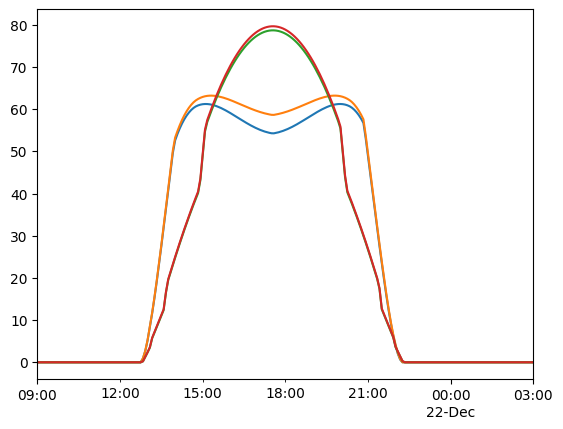

In [5]:
# make a plot
for i in range(0,num_plants):
    power_clear_sky[i].plot()
plt.show()